In [51]:
# Import necessary libraries
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from scipy import stats
import numpy as np
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate, cross_val_predict
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D, GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

In [53]:
# Read all files ending with .edf and .edf.seizures
all_files_path = glob(r"C:\Documents\FDA\Projects\OtherDataset\chb01\*.edf") + \
                 glob(r"C:\Documents\FDA\Projects\OtherDataset\chb01\*.edf.seizures")


print("Total files:", len(all_files_path))

Total files: 21


In [55]:
# Segregate files with seizures and their corresponding EEG data files
files_with_seizures = []
eeg_files_with_seizures = []

# Create a copy of the all_files_path list
all_file_path = all_files_path.copy()

for seizure_file_path in all_files_path:
    if '.edf.seizures' in seizure_file_path:
        # This is a seizure data file, so add it to the list
        files_with_seizures.append(seizure_file_path)

        # Extract the corresponding EEG data file name
        eeg_file_name = os.path.basename(seizure_file_path).replace('.edf.seizures', '.edf')
        eeg_file_path = next((path for path in all_files_path if eeg_file_name in path), None)

        if eeg_file_path:
            # Remove the corresponding EEG data file from the copy
            all_file_path.remove(eeg_file_path)
            eeg_files_with_seizures.append(eeg_file_path)

# Remove files with '.edf.seizures' extension from the remaining files
healthy_file_path = [path for path in all_file_path if '.edf.seizures' not in path]

# Print or use the segregated file paths
print("EEG files with seizures corresponding to seizure files:", len(eeg_files_with_seizures))
print(eeg_files_with_seizures)
print("Remaining files without seizures:", len(healthy_file_path))
print(healthy_file_path)

EEG files with seizures corresponding to seizure files: 7
['C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_03.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_04.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_15.edf.seizures', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_16.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_18.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_21.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_26.edf.seizures']
Remaining files without seizures: 9
['C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_01.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_02.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_05.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_06.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_17.edf', 'C:\\Documents\\FDA\\Projects\\OtherDataset\\chb01\\chb01_19.edf', 'C:\\Documents\

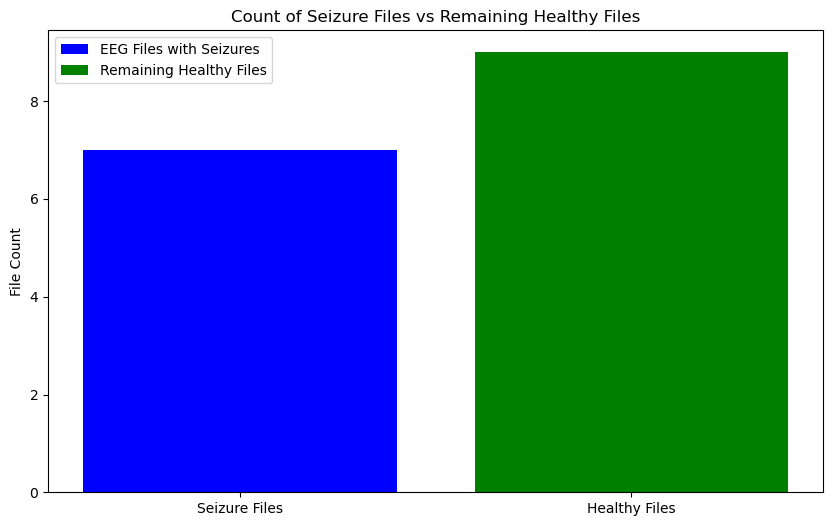

In [57]:
# Count of the files
seizure_files_count = len(files_with_seizures)
healthy_files_count = len(healthy_file_path)

# Visualization
plt.figure(figsize=(10, 6))

# Plotting the count of corresponding EEG files using a bar plot
plt.bar([0], [seizure_files_count], color='blue', label='EEG Files with Seizures')

# Plotting the count of remaining healthy files using a bar plot
plt.bar([1], [healthy_files_count], color='green', label='Remaining Healthy Files')

plt.xticks([0, 1], ['Seizure Files', 'Healthy Files'])
plt.ylabel('File Count')
plt.title('Count of Seizure Files vs Remaining Healthy Files')
plt.legend()
plt.show()

Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\117461896.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  seizure_raw = mne.io.read_raw_edf(seizure_file, preload=True)


Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\117461896.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  healthy_raw = mne.io.read_raw_edf(healthy_file, preload=True)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\117461896.py:13: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  seizure_raw.plot_psd(ax=ax[0], fmin=0, fmax=50, show=False)


Plotting power spectral density (dB=True).


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\117461896.py:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  healthy_raw.plot_psd(ax=ax[1], fmin=0, fmax=50, show=False)


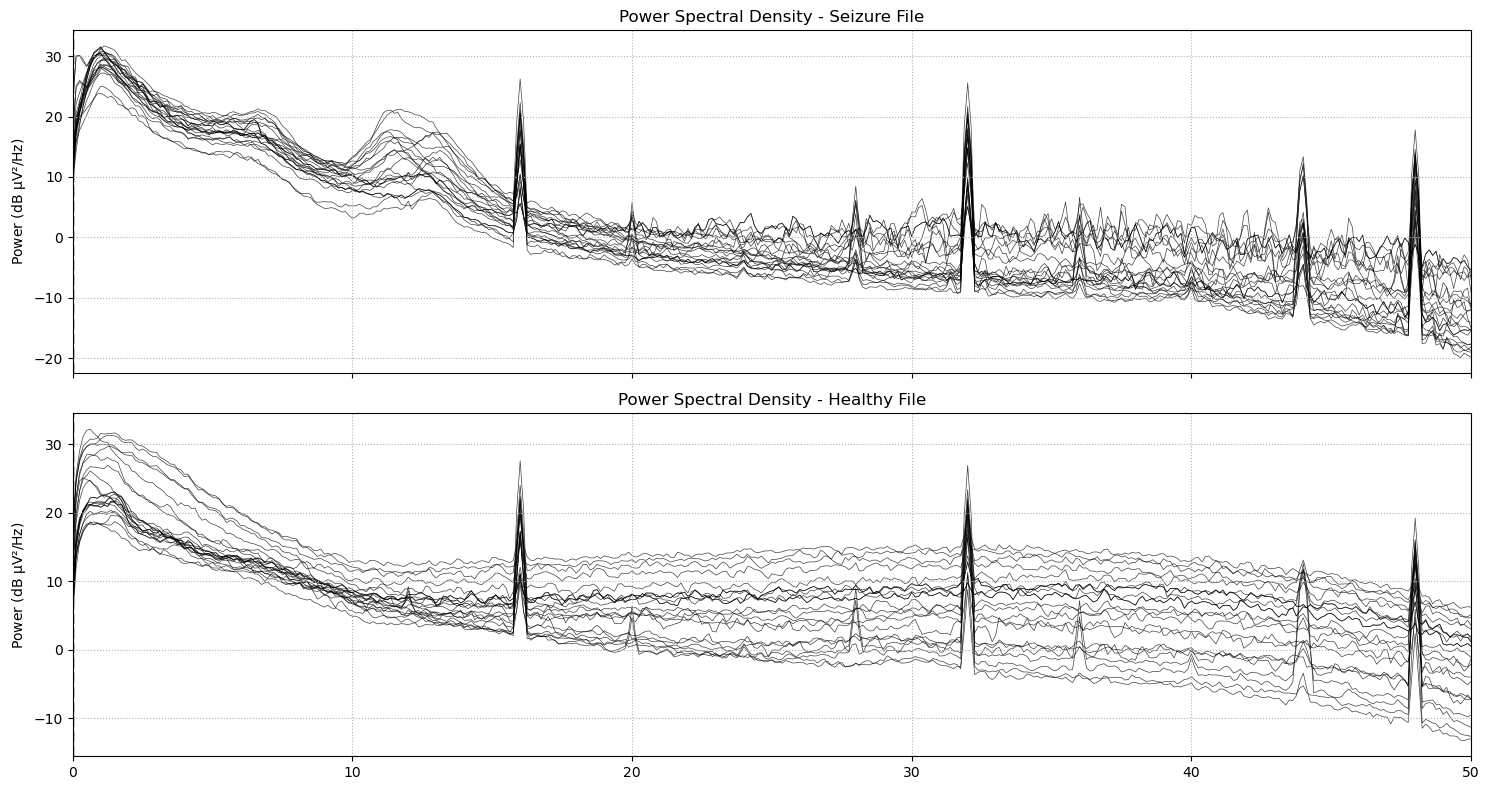

In [59]:
# Taking the first file from each path
seizure_file = eeg_files_with_seizures[0]
healthy_file = healthy_file_path[0]

# Reading EEG data from seizure file
seizure_raw = mne.io.read_raw_edf(seizure_file, preload=True)

# Reading EEG data from healthy file
healthy_raw = mne.io.read_raw_edf(healthy_file, preload=True)

# Plotting EEG data for one seizure file
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
seizure_raw.plot_psd(ax=ax[0], fmin=0, fmax=50, show=False)
ax[0].set_title('Power Spectral Density - Seizure File')

# Plotting EEG data for one healthy file
healthy_raw.plot_psd(ax=ax[1], fmin=0, fmax=50, show=False)
ax[1].set_title('Power Spectral Density - Healthy File')

plt.tight_layout()
plt.show()

In [61]:
# Define a function to read and preprocess EEG data from a given file
def read_data(file_path):
    # Read raw EEG data from the specified file and preload it into memory
    datax = mne.io.read_raw_edf(file_path, preload=True)
    
    # Print the shape of the original EEG data
    print("Original data shape:", datax.get_data().shape)

    # Set EEG reference to average reference and apply bandpass filtering (1-45 Hz)
    datax.set_eeg_reference()
    datax.filter(l_freq=1, h_freq=45)
    
    # Print the shape of the processed EEG data
    print("Processed data shape:", datax.get_data().shape)

    # Create fixed-length epochs from the preprocessed data with a specified duration and overlap
    epochs = mne.make_fixed_length_epochs(datax, duration=25, overlap=0)
    
    # Print the shape of the epochs data before loading
    print("Epochs data shape before loading:", epochs.get_data().shape)

    # Load the data into memory for all epochs, drop bad epochs, and print the number of remaining epochs
    epochs.load_data()
    epochs.drop_bad()
    print("Number of epochs created:", len(epochs))

    # Get the data from the epochs and print the final shape
    epochs_data = epochs.get_data()
    print("Final epochs data shape:", epochs_data.shape)

    # Return the preprocessed and segmented EEG data
    return epochs_data

In [63]:
# Checking if the function works as expected
datax=read_data(healthy_file_path[0])

Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)


In [65]:
# Getting the shape to have an idea for our input shape
datax.shape

(144, 23, 6400)

In [67]:
# Filtering all the files
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in eeg_files_with_seizures]

Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 681727  =      0.000 ...  2662.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 681728)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Processed data shape: (23, 681728)
Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 106 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (106, 23, 6400)
Using data from preloaded Raw for 106 events and 6400 original time points ...
Number of epochs created: 106
Final epochs data shape: (106, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153599  =      0.000 ...   599.996 secs...
Original data shape: (23, 153600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Processed data shape: (23, 153600)
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (24, 23, 6400)
Using data from preloaded Raw for 24 events and 6400 original time points ...
Number of epochs created: 24
Final epochs data shape: (24, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)
Extracting EDF parameters from C:\Documents\FDA\Projects\OtherDataset\chb01\chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1607341177.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  datax = mne.io.read_raw_edf(file_path, preload=True)


Original data shape: (23, 921600)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Processed data shape: (23, 921600)
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 6400 original time points ...
0 bad epochs dropped
Epochs data shape before loading: (144, 23, 6400)
Using data from preloaded Raw for 144 events and 6400 original time points ...
Number of epochs created: 144
Final epochs data shape: (144, 23, 6400)


NotImplementedError: Only EDF files are supported, got seizures.

In [69]:
# getting the length of the files for reference
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))

9 7


In [71]:
# Storing all files
data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels
print(len(data_list),len(label_list))

16 16


In [73]:
# Grouping the files
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

In [75]:
# Stacking the data
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
print(data_array.shape,label_array.shape,group_array.shape)

(2095, 23, 6400) (2095,) (2095,)


In [77]:
# Function to calculate the mean along the last axis of the input data
def mean(data):
    return np.mean(data, axis=-1)

# Function to calculate the standard deviation along the last axis of the input data
def std(data):
    return np.std(data, axis=-1)

# Function to calculate the peak-to-peak range along the last axis of the input data
def ptp(data):
    return np.ptp(data, axis=-1)

# Function to calculate the variance along the last axis of the input data
def var(data):
    return np.var(data, axis=-1)

# Function to find the minimum value along the last axis of the input data
def minim(data):
    return np.min(data, axis=-1)

# Function to find the maximum value along the last axis of the input data
def maxim(data):
    return np.max(data, axis=-1)

# Function to find the index of the minimum value along the last axis of the input data
def argminim(data):
    return np.argmin(data, axis=-1)

# Function to find the index of the maximum value along the last axis of the input data
def argmaxim(data):
    return np.argmax(data, axis=-1)

# Function to calculate the mean square along the last axis of the input data
def mean_square(data):
    return np.mean(data**2, axis=-1)

# Function to calculate the root mean square along the last axis of the input data
def rms(data):
    return np.sqrt(np.mean(data**2, axis=-1))

# Function to calculate the absolute differences between consecutive elements along the last axis
def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data, axis=-1)), axis=-1)

# Function to calculate the skewness along the last axis of the input data
def skewness(data):
    return stats.skew(data, axis=-1)

# Function to calculate the kurtosis along the last axis of the input data
def kurtosis(data):
    return stats.kurtosis(data, axis=-1)

# Function to concatenate a set of statistical features along the last axis of the input data
def concatenate_features(data):
    return np.concatenate((mean(data), std(data), ptp(data), var(data), minim(data), maxim(data),
                           argminim(data), argmaxim(data), mean_square(data), rms(data),
                           abs_diffs_signal(data), skewness(data), kurtosis(data)), axis=-1)

In [79]:
# Initialize an empty list to store computed features
features = []

# Iterate through each data array in the 'data_array' list
for data in tqdm_notebook(data_array):
    # Compute and append the concatenated features for the current data array
    features.append(concatenate_features(data))

# Convert the list of features into a NumPy array
features = np.array(features)

# Print the shape of the resulting features array
# print("Shape of the features array:", features.shape)

C:\Users\megha\AppData\Local\Temp\ipykernel_29472\1347266161.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/2095 [00:00<?, ?it/s]

In [81]:
# Initialize a Logistic Regression classifier with a specified maximum number of iterations
clf = LogisticRegression(max_iter=1000)

# Initialize a GroupKFold cross-validator with 5 splits
gkf = GroupKFold(n_splits=5)

# Define the parameter grid for hyperparameter tuning
param_grid = {'classifier__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 8, 10, 12, 15]}

# Create a pipeline with a standard scaler and the logistic regression classifier
pipe = Pipeline([('scaler', StandardScaler()), ('classifier', clf)])

# Initialize GridSearchCV with the pipeline, parameter grid, GroupKFold, and specified number of jobs
gscv = GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=16)

# Fit the GridSearchCV to the features, labels, and group information
gscv.fit(features, label_array, groups=group_array)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=16,
             param_grid={'classifier__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5,
                                           8, 10, 12, 15]})

In [83]:
# Getting the best score
gscv.best_score_

0.6689347935075516

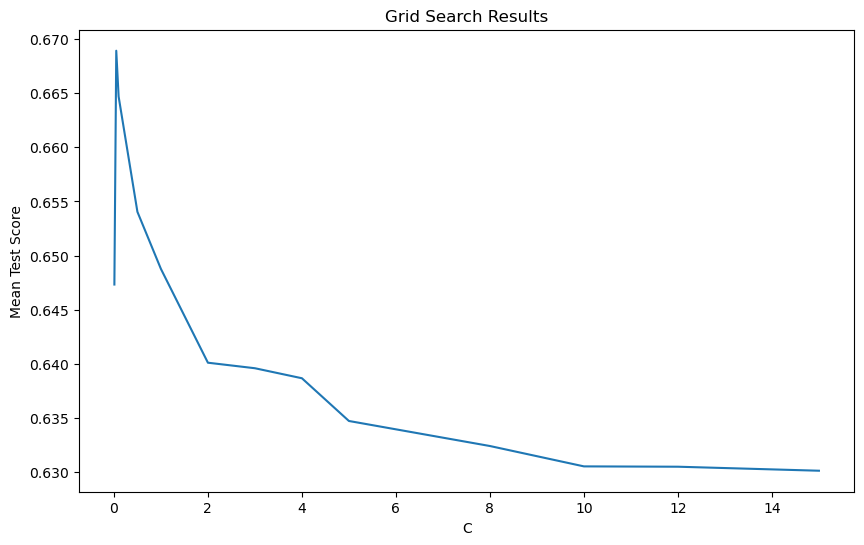

In [85]:
# Extract grid search results
results_df = pd.DataFrame(gscv.cv_results_)

# Plot mean test scores across different values of C
plt.figure(figsize=(10, 6))
sns.lineplot(x='param_classifier__C', y='mean_test_score', data=results_df)
plt.title('Grid Search Results')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.show()

Confusion Matrix:
[[641 497]
 [197 760]]

Precision: 0.6046141607000796
Recall: 0.7941483803552769
F1 Score: 0.6865401987353207


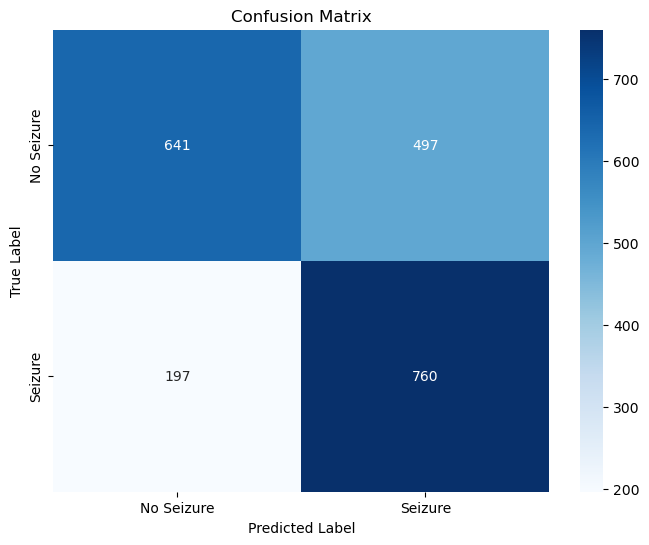

In [87]:
# Get the best estimator from the grid search cross-validation
best_clf = gscv.best_estimator_

# Use cross_val_predict to obtain predicted labels with cross-validation
y_pred = cross_val_predict(best_clf, features, label_array, groups=group_array, cv=gkf)

# Compute the confusion matrix
cm = confusion_matrix(label_array, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(label_array, y_pred)
recall = recall_score(label_array, y_pred)
f1 = f1_score(label_array, y_pred)

# Print the confusion matrix and evaluation metrics
print("Confusion Matrix:")
print(cm)
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Seizure', 'Seizure'], yticklabels=['No Seizure', 'Seizure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [89]:
# Function to define a CNN model
def cnnmodel():
    # Clear any previous TensorFlow sessions and models
    clear_session()

    # Create a Sequential model
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv1D(filters=3, kernel_size=3, strides=1, input_shape=(6400, 23)))  # 1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2, strides=2))  # 2

    # Convolutional Layer 2
    model.add(Conv1D(filters=3, kernel_size=3, strides=1))  # 3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2, strides=2))  # 4
    model.add(Dropout(0.3))

    # Convolutional Layer 3
    model.add(Conv1D(filters=3, kernel_size=3, strides=1))  # 5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2))  # 6
    model.add(Dropout(0.3))

    # Convolutional Layer 4
    model.add(Conv1D(filters=3, kernel_size=3, strides=1))  # 7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2))  # 8

    # Convolutional Layer 5
    model.add(Conv1D(filters=3, kernel_size=3, strides=1))  # 9
    model.add(LeakyReLU())

    # Global Average Pooling Layer
    model.add(GlobalAveragePooling1D())  # 10

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # 11

    # Compile the model with Adam optimizer and binary crossentropy loss
    model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create an instance of the CNN model
model = cnnmodel()

# Display the model summary
model.summary()

C:\Users\megha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6398, 3)        │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6398, 3)        │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6398, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3199, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3197, 3)        │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 3197, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1598, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1598, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1596, 3)        │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1596, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 798, 3)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 798, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 796, 3)         │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 796, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 398, 3)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 396, 3)         │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 396, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 3)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346 (1.35 KB)

 Trainable params: 340 (1.33 KB)

 Non-trainable params: 6 (24.00 B)

In [91]:
# Initialize GroupKFold with the default number of splits
gkf = GroupKFold()

# Initialize lists to store training and validation accuracies for each fold
train_accuracies = []
val_accuracies = []

# Initialize variables to track the best training and validation accuracies
best_train_accuracy = 0.0
best_val_accuracy = 0.0

# Iterate through the training and validation splits defined by GroupKFold
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    # Split data into training and validation sets
    train_features, train_labels = data_array[train_index], label_array[train_index]
    val_features, val_labels = data_array[val_index], label_array[val_index]

    # Transpose the features if necessary
    train_features = train_features.transpose(0, 2, 1)
    val_features = val_features.transpose(0, 2, 1)

    # Standardize features using the same scaler for both training and validation sets
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)

    # Create and train the CNN model
    model = cnnmodel()
    history = model.fit(train_features, train_labels, epochs=20, batch_size=128, validation_data=(val_features, val_labels))

    # Append training and validation accuracy values to the lists
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])

    # Evaluate accuracies for the current fold
    current_train_accuracy = history.history['accuracy'][-1]
    current_val_accuracy = history.history['val_accuracy'][-1]

    # Update the best training accuracy if the current training accuracy is higher
    if current_train_accuracy > best_train_accuracy:
        best_train_accuracy = current_train_accuracy

    # Update the best validation accuracy if the current validation accuracy is higher
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy

# Print the best training and validation accuracies
print("Best Training Accuracy:", best_train_accuracy)
print("Best Validation Accuracy:", best_val_accuracy)

C:\Users\megha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.5945 - loss: 0.6829 - val_accuracy: 0.3333 - val_loss: 0.7285
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5861 - loss: 0.6698 - val_accuracy: 0.3333 - val_loss: 0.7557
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6013 - loss: 0.6568 - val_accuracy: 0.3333 - val_loss: 0.7773
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6007 - loss: 0.6487 - val_accuracy: 0.3333 - val_loss: 0.7823
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5813 - loss: 0.6506 - val_accuracy: 0.3333 - val_loss: 0.7687
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6021 - loss: 0.6324 - val_accuracy: 0.3333 - val_loss: 0.7636
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5880 - loss: 0.6272 - val_accuracy: 0.3333 - val_loss: 0.7389
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6067 - loss: 0.6022 - val_accuracy: 0.3333 - 

C:\Users\megha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.4857 - loss: 0.6943 - val_accuracy: 0.3333 - val_loss: 0.6964
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4845 - loss: 0.6926 - val_accuracy: 0.3588 - val_loss: 0.6943
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5302 - loss: 0.6921 - val_accuracy: 0.6019 - val_loss: 0.6932
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6317 - loss: 0.6911 - val_accuracy: 0.6157 - val_loss: 0.6925
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6571 - loss: 0.6898 - val_accuracy: 0.5440 - val_loss: 0.6927
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6570 - loss: 0.6884 - val_accuracy: 0.5139 - val_loss: 0.6932
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6522 - loss: 0.6847 - val_accuracy: 0.5394 - val_loss: 0.6936
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6981 - loss: 0.6772 - val_accuracy: 0.5278 - 

C:\Users\megha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.4786 - loss: 0.7035 - val_accuracy: 0.3333 - val_loss: 0.7130
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4985 - loss: 0.6948 - val_accuracy: 0.3333 - val_loss: 0.6988
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4920 - loss: 0.6940 - val_accuracy: 0.4213 - val_loss: 0.6920
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5312 - loss: 0.6932 - val_accuracy: 0.5694 - val_loss: 0.6894
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5286 - loss: 0.6925 - val_accuracy: 0.6412 - val_loss: 0.6877
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5494 - loss: 0.6916 - val_accuracy: 0.5509 - val_loss: 0.6874
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5976 - loss: 0.6907 - val_accuracy: 0.4745 - val_loss: 0.6869
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6253 - loss: 0.6895 - val_accuracy: 0.4352 - 

C:\Users\megha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5615 - loss: 0.6923 - val_accuracy: 0.6624 - val_loss: 0.6920
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5730 - loss: 0.6906 - val_accuracy: 0.6320 - val_loss: 0.6901
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5663 - loss: 0.6875 - val_accuracy: 0.6371 - val_loss: 0.6881
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5607 - loss: 0.6830 - val_accuracy: 0.6497 - val_loss: 0.6866
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5609 - loss: 0.6777 - val_accuracy: 0.6244 - val_loss: 0.6865
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5983 - loss: 0.6658 - val_accuracy: 0.6091 - val_loss: 0.6841
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6363 - loss: 0.6501 - val_accuracy: 0.5736 - val_loss: 0.6885
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6871 - loss: 0.6202 - val_accuracy: 0.5711 - 

C:\Users\megha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.5683 - loss: 0.6898 - val_accuracy: 0.4148 - val_loss: 0.6985
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5496 - loss: 0.6854 - val_accuracy: 0.4148 - val_loss: 0.7043
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5656 - loss: 0.6784 - val_accuracy: 0.4148 - val_loss: 0.7114
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5772 - loss: 0.6703 - val_accuracy: 0.4148 - val_loss: 0.7162
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5713 - loss: 0.6634 - val_accuracy: 0.4148 - val_loss: 0.7195
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5873 - loss: 0.6499 - val_accuracy: 0.4148 - val_loss: 0.7124
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5689 - loss: 0.6500 - val_accuracy: 0.4148 - val_loss: 0.6930
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5751 - loss: 0.6416 - val_accuracy: 0.4148 - 

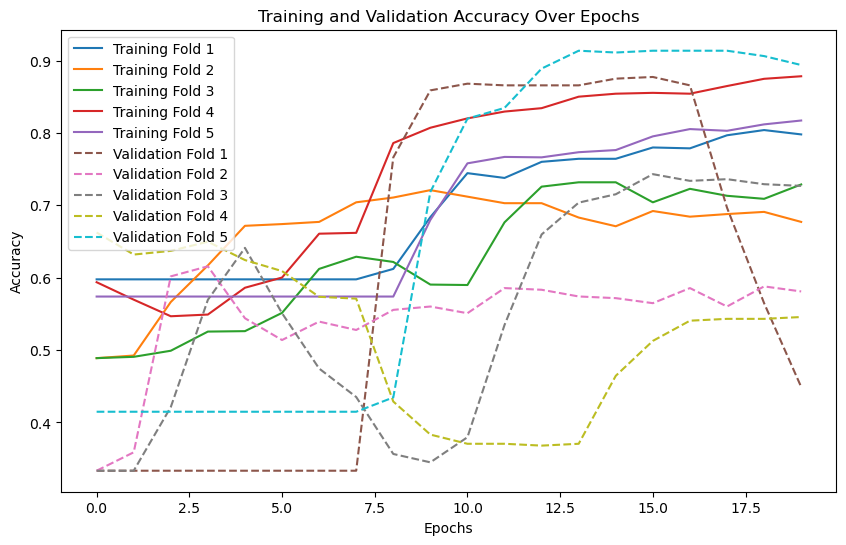

In [93]:
# Plotting the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))

for i in range(len(train_accuracies)):
    plt.plot(train_accuracies[i], label=f'Training Fold {i+1}')

for i in range(len(val_accuracies)):
    plt.plot(val_accuracies[i], label=f'Validation Fold {i+1}', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()